# Super Simple Keras model on TriFeature for multiplicity determination

In [1]:
features = ["T", "E", "Size", "EToF", "EnergyMoment", "TSpawn", "MaxEHit", "X", "Y", "Z"]
label = "prim"
dp = 30
neutrons = [1, 2, 3, 4]

In [2]:
import tensorflow
from tensorflow import keras

print("tensorflow", tensorflow.__version__)
print("keras", keras.__version__)

tensorflow 2.3.1
keras 2.4.0


In [3]:
import sys
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
import sklearn.preprocessing
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

sys.path.append("..")
from helpers import filename_for

Welcome to JupyROOT 6.16/00


In [4]:
files = [filename_for(15, dp, 600, 500, n, "inclxx", s, "clusterfeature.parquet") for n in neutrons for s in range(20)]
dfs = [pd.read_parquet(file) for file in files]
data = pd.concat(dfs, ignore_index=True).sample(frac=1, random_state=1337)

data = data[(abs(data["X"]) < 125) & (abs(data["Y"]) < 125) & (data["T"] < 100)]

print(data["prim"].value_counts())
display(data)

0.0    8499721
1.0    1779876
Name: prim, dtype: int64


,i_event,prim,T,E,Size,EToF,EnergyMoment,TSpawn,MaxEHit,X,Y,Z
3499177,1731.0,1.0,63.755749,149.914871,6.0,607.207764,6.798460e+00,1.218181,64.293854,-0.682722,-22.500000,1522.5
8869071,3484.0,0.0,74.362877,15.335159,4.0,580.952515,3.743494e+00,0.394498,9.338829,37.500000,-1.970521,1757.5
2585062,5713.0,0.0,68.605553,37.585819,1.0,600.481689,2.278178e-13,0.000000,37.585819,-76.964607,2.500000,1632.5
2894202,5004.0,0.0,74.553833,34.140911,2.0,625.573181,2.255625e+00,0.020336,23.147533,-6.335686,17.500000,1792.5
3878350,5814.0,0.0,86.484261,7.983827,1.0,264.821777,0.000000e+00,0.000000,7.983827,98.367348,67.500000,1622.5
...,...,...,...,...,...,...,...,...,...,...,...,...
480729,1884.0,0.0,79.410904,2.277636,1.0,296.172211,0.000000e+00,0.000000,2.277636,-72.500000,-76.763123,1547.5
3361959,3033.0,1.0,63.699387,613.164795,38.0,609.370972,3.672803e+01,5.340049,52.407722,3.392983,12.500000,1522.5
7087336,7733.0,0.0,70.274147,246.902069,11.0,568.768555,1.244804e+01,2.275502,52.906334,6.802186,37.500000,1652.5
8315069,6834.0,0.0,78.157318,2.550865,1.0,425.412720,0.000000e+00,0.000000,2.550865,41.877541,82.500000,1702.5


In [5]:
scaler = sklearn.preprocessing.RobustScaler()
data[features] = scaler.fit_transform(data[features])
joblib.dump(scaler, "models/keras-scaler.pkl.gz")
display(data)

,i_event,prim,T,E,Size,EToF,EnergyMoment,TSpawn,MaxEHit,X,Y,Z
3499177,1731.0,1.0,-0.915362,2.941262,5.0,0.619041,2.632025e+00,4.267230,1.836347,-0.014907,-0.499564,-0.695652
8869071,3484.0,0.0,0.421493,0.165774,3.0,0.444560,1.449294e+00,1.381907,0.081351,0.835383,-0.042687,1.347826
2585062,5713.0,0.0,-0.304123,0.624658,0.0,0.574343,1.719292e-16,0.000000,0.983423,-1.713625,0.056803,0.260870
2894202,5004.0,0.0,0.445560,0.553612,1.0,0.741089,8.732656e-01,0.071235,0.522334,-0.140792,0.390623,1.652174
3878350,5814.0,0.0,1.949196,0.014165,0.0,-1.656303,-8.802777e-14,0.000000,0.038079,2.190835,1.503356,0.173913
...,...,...,...,...,...,...,...,...,...,...,...,...
480729,1884.0,0.0,1.057715,-0.103516,0.0,-1.447962,-8.802777e-14,0.000000,-0.144149,-1.614203,-1.707171,-0.478261
3361959,3033.0,1.0,-0.922466,12.495040,37.0,0.633417,1.421927e+01,18.705935,1.456762,0.075855,0.279349,-0.695652
7087336,7733.0,0.0,-0.093824,4.941465,10.0,0.363591,4.819260e+00,7.970973,1.472685,0.151774,0.835716,0.434783
8315069,6834.0,0.0,0.899721,-0.097881,0.0,-0.589087,-8.802777e-14,0.000000,-0.135424,0.932866,1.837176,0.869565


In [6]:
prim1 = data[data["prim"] == 1]
prim0 = data[data["prim"] == 0].sample(n=len(prim1.index), random_state=1337)
balanced_data = pd.concat([prim0, prim1], ignore_index=True).sample(frac=1, random_state=1337)

print(balanced_data["prim"].value_counts())

1.0    1779876
0.0    1779876
Name: prim, dtype: int64


In [7]:
msk = np.random.rand(len(balanced_data)) < 0.8
traindata = balanced_data[msk]
testdata = balanced_data[~msk]

print(traindata.shape, testdata.shape)

(2847524, 12) (712228, 12)


In [8]:
x_train = traindata[features].values
y_train = keras.utils.to_categorical(traindata[[label]].values.ravel())

x_val = testdata[features].values
y_val = keras.utils.to_categorical(testdata[[label]].values.ravel())

In [9]:
models = defaultdict(keras.models.Sequential)

models["SM"].add(keras.layers.Dense(units=2, activation="softmax"))

models["10-SM"].add(keras.layers.Dense(units=10, activation="relu"))
models["10-SM"].add(keras.layers.Dense(units=2, activation="softmax"))

models["20-SM"].add(keras.layers.Dense(units=20, activation="relu"))
models["20-SM"].add(keras.layers.Dense(units=2, activation="softmax"))

models["100-SM"].add(keras.layers.Dense(units=100, activation="relu"))
models["100-SM"].add(keras.layers.Dense(units=2, activation="softmax"))

models["100-10-SM"].add(keras.layers.Dense(units=100, activation="relu"))
models["100-10-SM"].add(keras.layers.Dense(units=10, activation="relu"))
models["100-10-SM"].add(keras.layers.Dense(units=2, activation="softmax"))

models["1000-100-SM"].add(keras.layers.Dense(units=1000, activation="relu"))
models["1000-100-SM"].add(keras.layers.Dense(units=100, activation="relu"))
models["1000-100-SM"].add(keras.layers.Dense(units=2, activation="softmax"))

# models["3000-200-100-SM"].add(keras.layers.Dense(units=3000, activation="relu"))
# models["3000-200-100-SM"].add(keras.layers.Dense(units=200, activation="relu"))
# models["3000-200-100-SM"].add(keras.layers.Dense(units=10, activation="relu"))
# models["3000-200-100-SM"].add(keras.layers.Dense(units=2, activation="softmax"))

optimizer = keras.optimizers.Adam
loss = keras.losses.CategoricalCrossentropy

histories = {}
for name, model in models.items():
    print(name)
    model.compile(loss=loss(), optimizer=optimizer(), metrics=["accuracy"])
    histories[name] = model.fit(
        x=x_train, y=y_train, batch_size=1000, epochs=50, validation_data=(x_val, y_val), verbose=2
    )
    model.save(f"models/keras-{name}")
    print("----")

SM
Epoch 1/50
2848/2848 - 3s - loss: 0.3650 - accuracy: 0.8469 - val_loss: 0.3109 - val_accuracy: 0.8757
Epoch 2/50
2848/2848 - 3s - loss: 0.3054 - accuracy: 0.8795 - val_loss: 0.3041 - val_accuracy: 0.8815
Epoch 3/50
2848/2848 - 3s - loss: 0.3033 - accuracy: 0.8821 - val_loss: 0.3038 - val_accuracy: 0.8820
Epoch 4/50
2848/2848 - 3s - loss: 0.3028 - accuracy: 0.8823 - val_loss: 0.3031 - val_accuracy: 0.8822
Epoch 5/50
2848/2848 - 3s - loss: 0.3023 - accuracy: 0.8823 - val_loss: 0.3026 - val_accuracy: 0.8821
Epoch 6/50
2848/2848 - 3s - loss: 0.3018 - accuracy: 0.8823 - val_loss: 0.3023 - val_accuracy: 0.8817
Epoch 7/50
2848/2848 - 3s - loss: 0.3013 - accuracy: 0.8823 - val_loss: 0.3017 - val_accuracy: 0.8823
Epoch 8/50
2848/2848 - 3s - loss: 0.3009 - accuracy: 0.8823 - val_loss: 0.3014 - val_accuracy: 0.8820
Epoch 9/50
2848/2848 - 3s - loss: 0.3004 - accuracy: 0.8823 - val_loss: 0.3009 - val_accuracy: 0.8821
Epoch 10/50
2848/2848 - 3s - loss: 0.3000 - accuracy: 0.8824 - val_loss: 0.3004

2020-11-25 22:13:30.982612: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /data/jmayer/Simulations/R3BRoot/build/lib:/data/jmayer/Simulations/2019-09-04/ucesb/hbook:/data/jmayer/Simulations/2019-09-04/FairRoot/lib:/data/jmayer/Simulations/2019-09-04/FairSoft/lib/root:/data/jmayer/Simulations/2019-09-04/FairSoft/lib
2020-11-25 22:13:30.982682: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2020-11-25 22:13:30.982732: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (poseidon.ikp.uni-koeln.de): /proc/driver/nvidia/version does not exist
2020-11-25 22:13:31.088843: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2600050000 Hz
2020-11-25 22:13:31.092340: I tensorflow/compiler/xla/service/

In [10]:
x_test = testdata[features].values
y_true = testdata[[label]].values.ravel()

# x_all = data[features].values
# y_all = data[[label]].values.ravel()

for name, model in models.items():
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    bac = balanced_accuracy_score(y_true, y_pred)

    # y_pred_all = model.predict(x_all)
    # y_pred_all = np.argmax(y_pred_all, axis=1)
    # bac_all = balanced_accuracy_score(y_all, y_pred_all)

    print(name, bac)  # , bac_all)

SM 0.882789267328322
10-SM 0.9097371647833205
20-SM 0.9104730572864561
100-SM 0.9123248659488798
100-10-SM 0.9135735827669402
1000-100-SM 0.9137991438172028


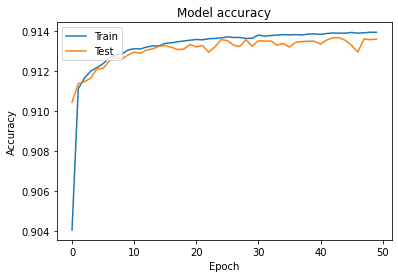

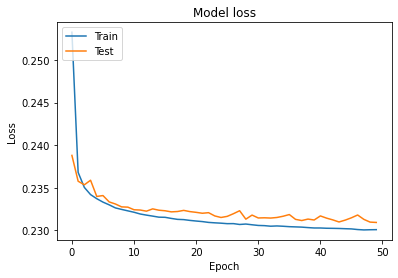

In [12]:
history = histories["100-10-SM"]

# Plot training & validation accuracy values
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

In [17]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

y_pred = models["20-SM"].predict(x_test)
# print(y_pred[:, 1].shape)
# print(y_pred[:, 1])
y_pred = np.argmax(y_pred, axis=1)
# print(y_true)

bac = balanced_accuracy_score(y_true, y_pred)
print(bac)
cm = confusion_matrix(y_true, y_pred, labels=range(0, 2))
print(cm)
cmrel = confusion_matrix(y_true, y_pred, labels=range(0, 2), normalize="true")
print(cmrel)

(712228,)
[0.368 0.078 1.    ... 0.952 0.984 0.768]
[1. 0. 1. ... 0. 1. 1.]
0.9104730572864561
[[317275  38530]
 [ 25222 331201]]
[[0.892 0.108]
 [0.071 0.929]]
